In [1]:
# install.packages('cowplot')
# install.packages('rjags')
# install.packages('showtext')
# install.packages('BayesianTools')

# Important equations
Full width at half maximum:
$$
\text{FWHM} = \sqrt{w_{d}^{2} + w_{e}^2}
$$


Device resolution
$$
w_d = 2\sqrt{\left(2\ln 2\right) \cdot F \cdot E_{\gamma} \cdot w}
$$

# Initialize libs, data, useful functions

In [234]:
library(tidyverse)
library(cowplot)
library(magrittr)
library('rjags')
library(showtext)
library(BayesianTools)
fig <- function(width, height){
     options(repr.plot.width = width, repr.plot.height = height)
}



th_path = 'data/IC48A_Th.txt'
AmCsCo_path = 'data/IC48A_AmCsCo.txt'

th_data = read.table(th_path, col.names = c('Ch', 'counts'))
th_peaks = c(238.632, 300.089, 510.74, 583.187, 727.330, 763.45, 785.37, 860.53, 893.408, 1078.63, 1512.70, 1592.511, 1620.738, 2103.511, 2614.511)

acc_data = read.table(AmCsCo_path, col.names = c('Ch', 'counts'))
acc_peaks = c(59.5409, 661.657, 1173.228, 1332.492, 2505.69)


calc_fwhm <- function(wd, we) {
    return(sqrt(wd^2 + we^2))
}
calc_wd <- function(fano, E_ph, w) {
    return(2*sqrt(2*log(2)*fano*E_ph*w))
}

# Plot raw data

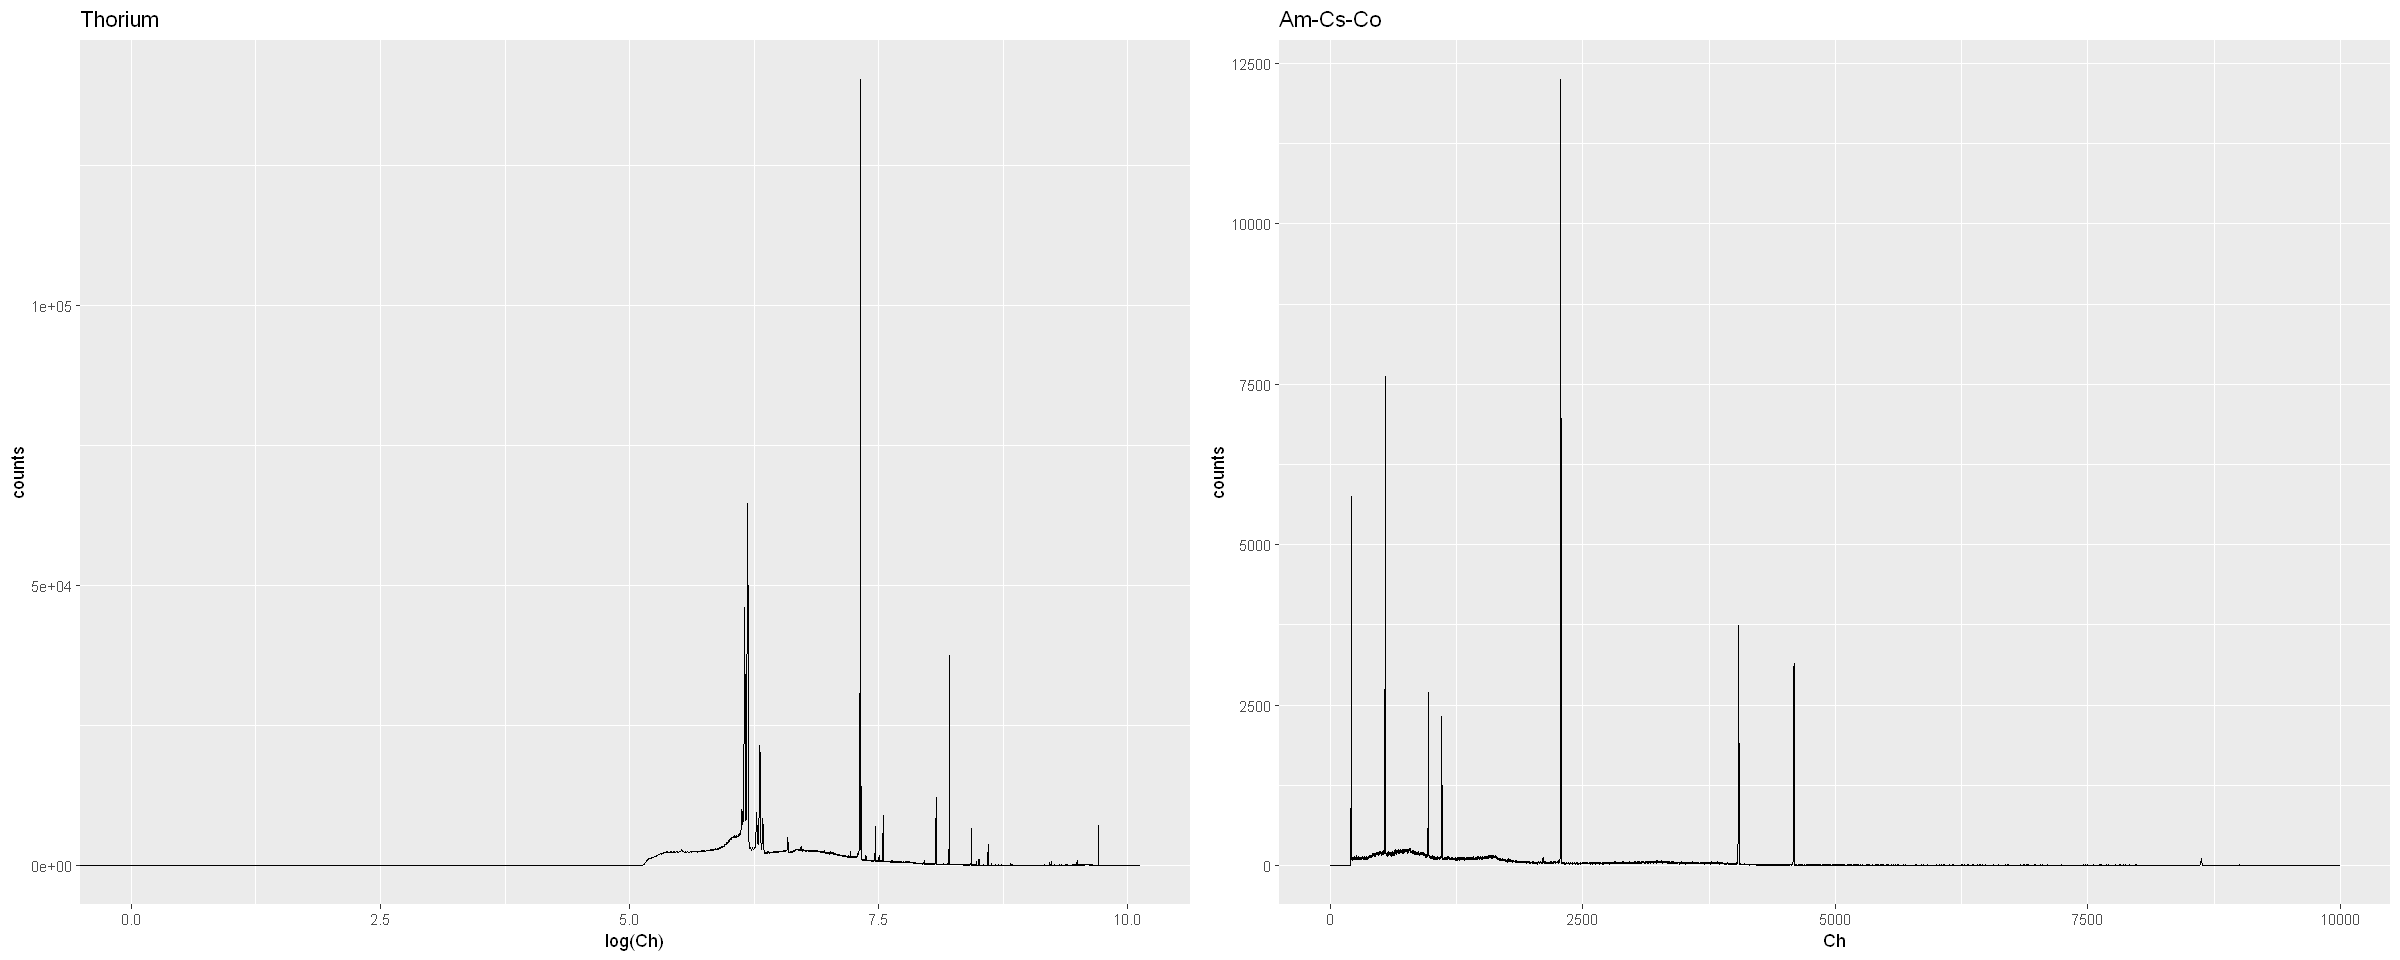

In [237]:
fig(20,8)

p_th = ggplot(data = th_data, mapping = aes(x = log(Ch), y = counts)) + 
    geom_line() +
    ggtitle('Thorium')

p_acc = ggplot(data = acc_data, mapping = aes(x = Ch, y = counts)) + 
    geom_line() +
    ggtitle('Am-Cs-Co')

plot_grid(p_th, p_acc)

In [387]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}

grab_peak <- function(segment, data, peak_width){
    
    #finds the Ch corresponding to the maximum no. of counts
    peak_ch <- filter(segment, counts == max(counts))$Ch
    
    #slices the original dataframe symmetrically around the channel found with filter()
    peak_data <- data[(peak_ch - peak_width%/%2):(peak_ch + peak_width%/%2),]
    return(peak_data)
}


probe_peaks <- function(data, search_width, pk_size, peak_width = 20){

    peaks_list <- NULL
    counter <- 0
    for(i in seq(0, length(data$counts) - search_width, search_width)){
        
        #set up a data segment of (search_width) points to search over
        segment <- data[i:(i + search_width),]
        
        #Convert to log in case the count is too large
        log_counts <- sapply(segment$counts, log)
        
        segment$counts[which(!is.finite(log_counts))] <- 0
        #Check if data segment exceeds threshold
        if(log(range_size(segment$counts) ) < log(pk_size)){
            next
        }
        else{
            counter <- counter + 1
            
            #Make list of data.frame elements
            peaks_list[[counter]] <- grab_peak(segment, data, peak_width)
            #Rename each pair of data.frame columns appended to the list Xcounter and Ycounter
            colnames(peaks_list[[counter]]) <- c(paste('X', counter, sep = ''), paste('Y', counter, sep = ''))
        }
    }
    #bind all columns in the list together into a single dataframe
    centered_peaks <- bind_cols(peaks_list)
    return(centered_peaks)
}

centered_peaks_acc <- probe_peaks(acc_data, 80, 2000, peak_width = 60)
centered_peaks_th <- probe_peaks(th_data, 80, 2000, peak_width = 60)

In [388]:
head(centered_peaks_th) ; head(centered_peaks_acc)

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,⋯,X11,Y11,X12,Y12,X13,Y13,X14,Y14,X15,Y15
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,⋯,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
1,186,1359,440,5158,454,6538,534,6547,695,2460,⋯,3642,350,3648,564,4549,201,5388,107,16418,579
2,187,1366,441,5262,455,7359,535,5466,696,2621,⋯,3643,402,3649,577,4550,198,5389,85,16419,628
3,188,1492,442,5255,456,8208,536,4720,697,2545,⋯,3644,427,3650,597,4551,200,5390,93,16420,660
4,189,1488,443,5493,457,9401,537,4098,698,2473,⋯,3645,470,3651,662,4552,176,5391,110,16421,662
5,190,1519,444,5425,458,9996,538,3860,699,2639,⋯,3646,443,3652,765,4553,205,5392,98,16422,707
6,191,1533,445,5416,459,9532,539,3776,700,2518,⋯,3647,522,3653,798,4554,172,5393,120,16423,755


,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6,X7,Y7
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
1,175,0,512,190,938,163,1071,125,2249,60,4011,30,4559,14
2,176,0,513,206,939,129,1072,131,2250,53,4012,23,4560,9
3,177,0,514,181,940,177,1073,129,2251,54,4013,32,4561,9
4,178,0,515,210,941,154,1074,113,2252,51,4014,23,4562,16
5,179,0,516,168,942,149,1075,116,2253,56,4015,20,4563,10
6,180,0,517,180,943,139,1076,94,2254,54,4016,35,4564,14


In [389]:
plot_peaks <- function(peaks){
    the_plot <- ggplot(data = peaks)
    x_vars <- NULL; y_vars <- NULL
    for(name in colnames(peaks)){
        if(strsplit(name, '')[[1]][[1]]== 'X'){
            x_vars <- c(x_vars, name)
        }
        else if(strsplit(name, '')[[1]][[1]] == 'Y'){
            y_vars <- c(y_vars, name)
        }
    }
    for(i in seq_along(x_vars)){
        the_plot <- the_plot + geom_line(aes_string(x = x_vars[i],y = y_vars[i]))
    }
    the_plot <- the_plot + xlab('Ch') + ylab('counts')
    return(the_plot)
}

acc_p <- plot_peaks(centered_peaks_acc)
th_p <- plot_peaks(centered_peaks_th)

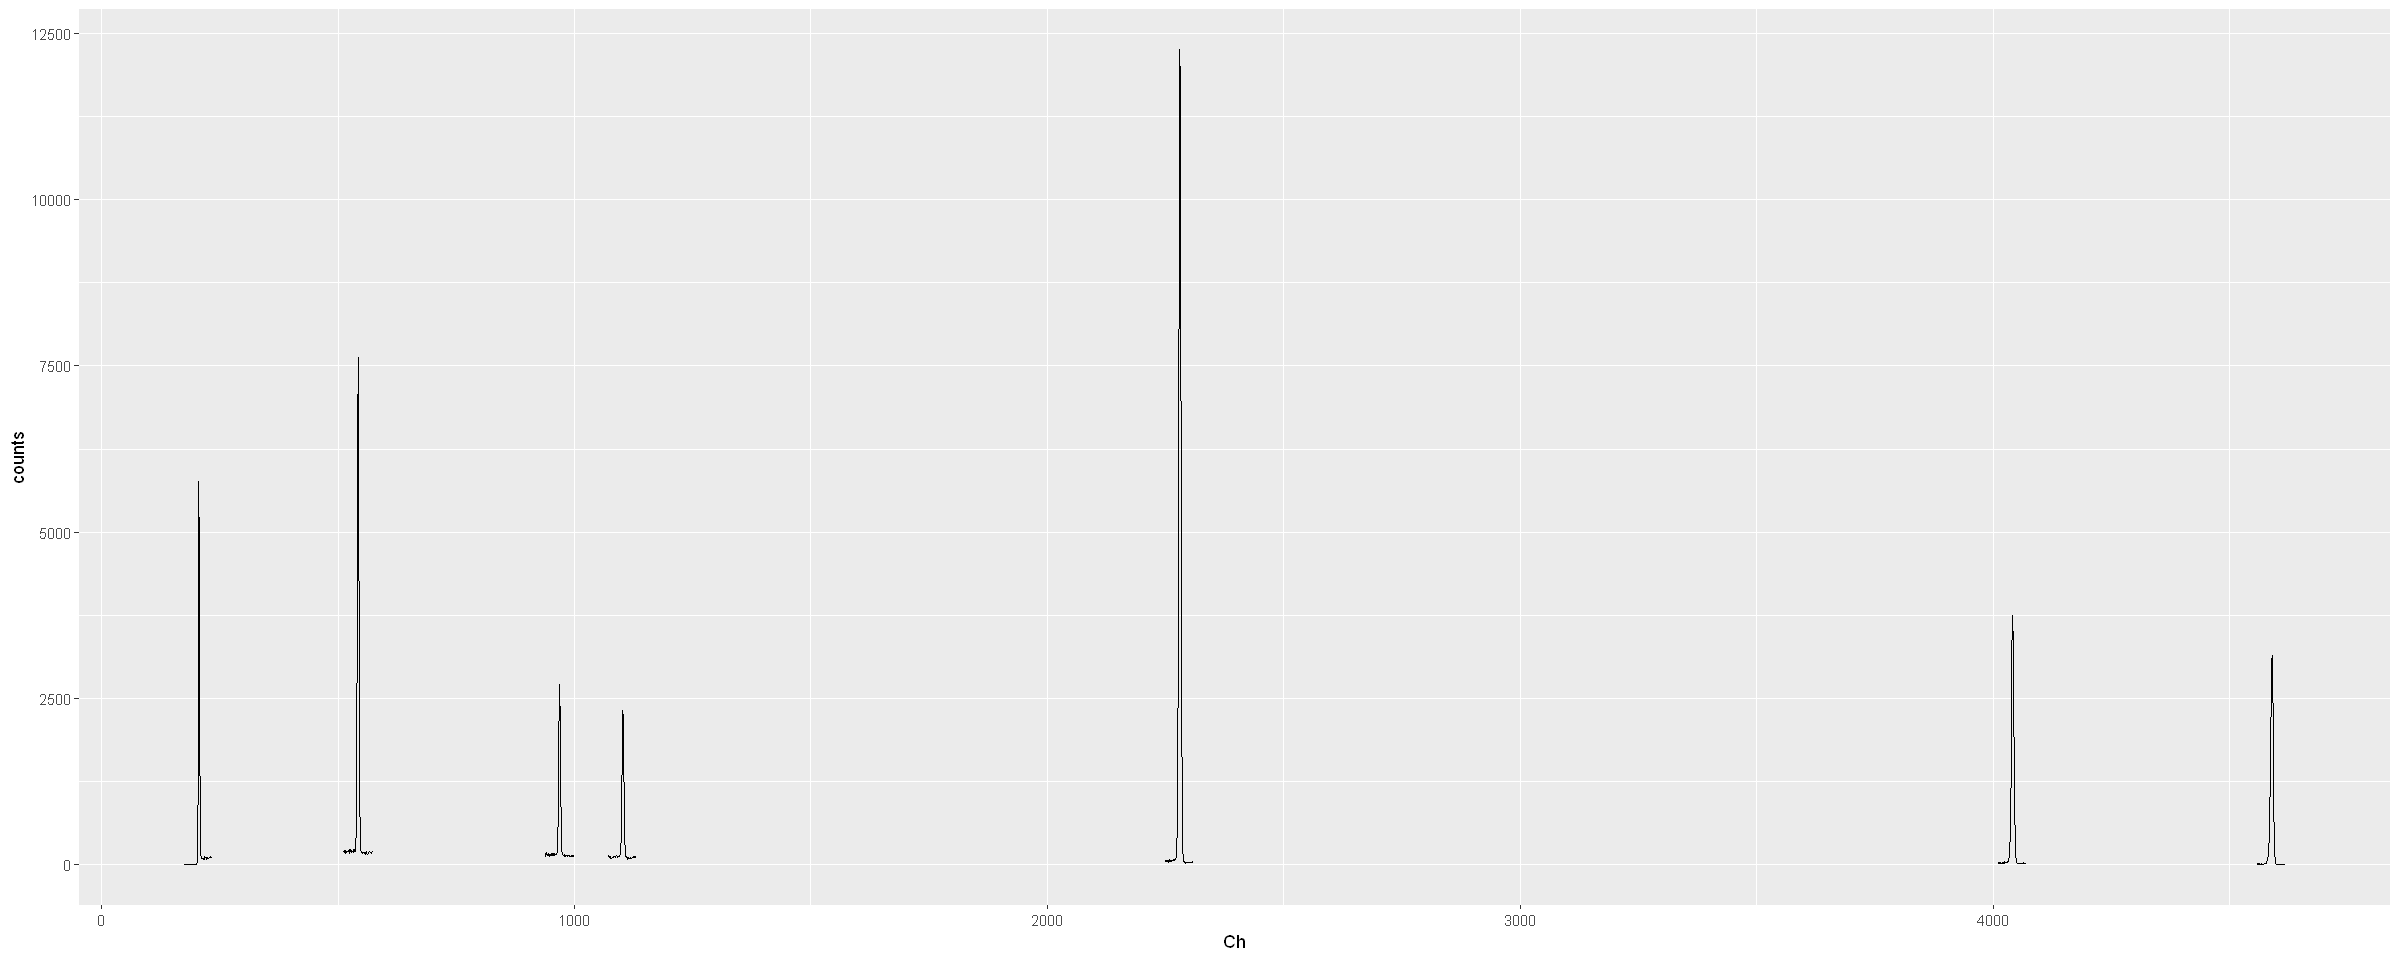

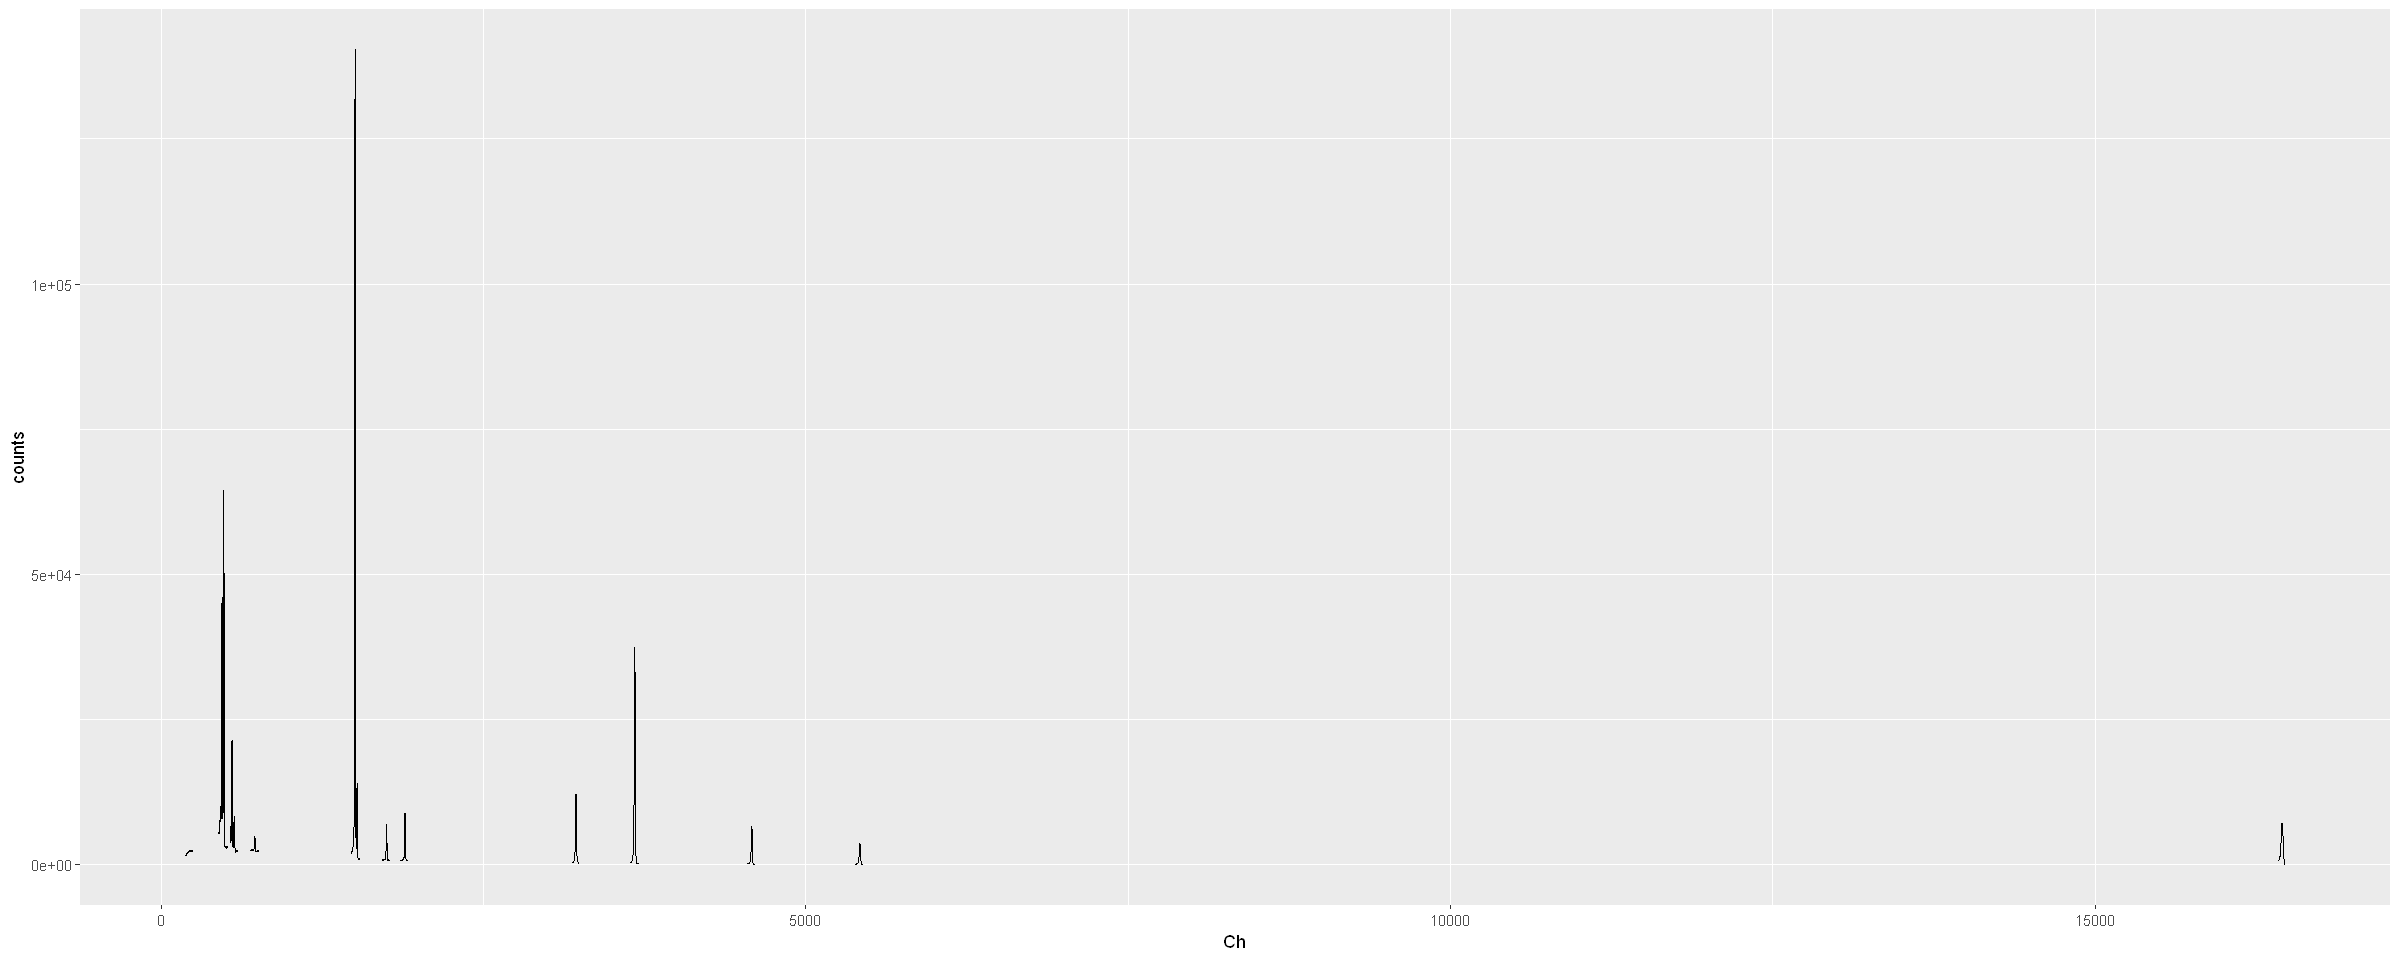

In [390]:
acc_p ; th_p

In [353]:
strsplit(name, '')[[1]][[1]]



[1] "Y"

In [301]:
sapply(colnames(centered_peaks_acc), strsplit, '')

$X1
[1] "X" "1"

$Y1
[1] "Y" "1"

$X2
[1] "X" "2"

$Y2
[1] "Y" "2"

$X3
[1] "X" "3"

$Y3
[1] "Y" "3"

$X4
[1] "X" "4"

$Y4
[1] "Y" "4"

$X5
[1] "X" "5"

$Y5
[1] "Y" "5"

$X6
[1] "X" "6"

$Y6
[1] "Y" "6"

$X7
[1] "X" "7"

$Y7
[1] "Y" "7"

In [298]:
?apply

apply {base},R Documentation
X,"an array, including a matrix."
MARGIN,"a vector giving the subscripts which the function will be applied over. E.g., for a matrix 1 indicates rows, 2 indicates columns, c(1, 2) indicates rows and columns. Where X has named dimnames, it can be a character vector selecting dimension names."
FUN,"the function to be applied: see ‘Details’. In the case of functions like +, %*%, etc., the function name must be backquoted or quoted."
...,optional arguments to FUN.
simplify,a logical indicating whether results should be simplified if possible.


In [73]:
a <- c(1, 2, 3, 4, 5)
a[-0:10]

[1]  1  2  3  4  5 NA NA NA NA NA

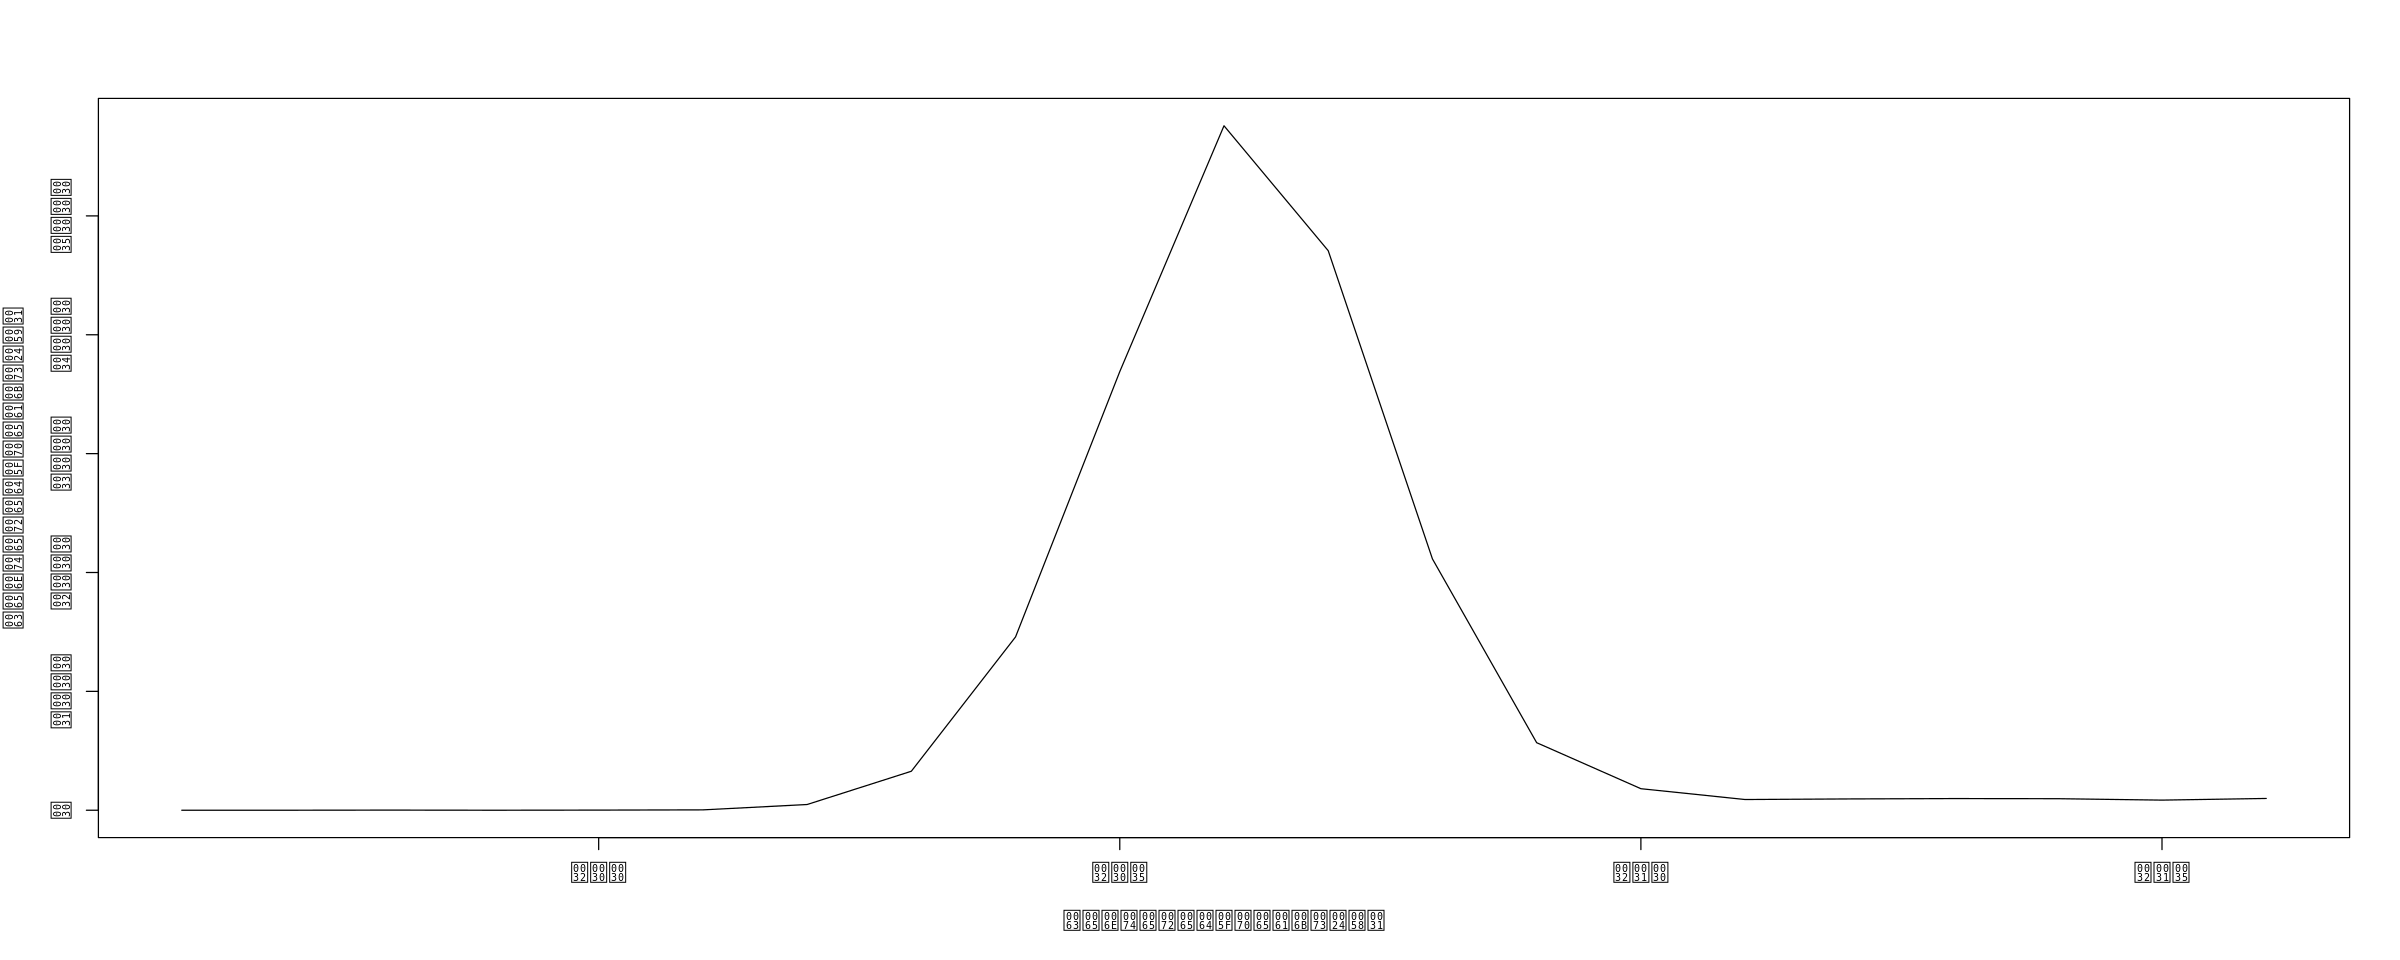

In [9]:
plot(centered_peaks$X1,centered_peaks$Y1,type="l")

In [399]:
cat('a suca suca', 1,'b', sep = '')

a suca suca1b NULL


[1] 1

[1] 2

In [397]:
likelihood_str <- 'for (i in 1:length(x)){
S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)
y[i] ~ dpois(S[i])
}'
priors_str <- 'A ~ dnorm(",A.max,",",50,")
B ~ dnorm(",B.max,",",10,")
x0 ~ dunif(",x0.min,",",x0.max,")
w ~ dunif(1,10)'

cat("model{

            #The likelihood: 
",likelihood_str,"

            # Priors for  A, B, x0, w 
",priors_str,"

        }", sep = '') #file=paste("Models/model_peak_",i,".bug",sep=""))



model{

            #The likelihood: 
for (i in 1:length(x)){
S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)
y[i] ~ dpois(S[i])
}

            # Priors for  A, B, x0, w 
A ~ dnorm(",A.max,",",50,")
B ~ dnorm(",B.max,",",10,")
x0 ~ dunif(",x0.min,",",x0.max,")
w ~ dunif(1,10)

        }